In [1]:
from pnet import pnet_loader, Pnet
from util import util, sankey_diag

import torch
import random
import seaborn as sns
import pandas as pd
import os
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
import torch.nn.functional as F
import torch.nn as nn
import numpy as np



%load_ext autoreload
%autoreload 2

/opt/conda/envs/pnet/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def read_hyper_result(path, run_name):
    hparam_names = ['weight_decay', 'input_dropout', 'dropout', 'learning_rate', 'batch_size']
    hparam_values = [param[2:] for param in run_name.split('_')]
    dict_ = dict(zip(hparam_names, hparam_values))
    
    loss = pd.read_csv(path+run_name+'/loss.csv')
    dict_['auc'] = loss['auc'][0]    
    df = pd.DataFrame.from_dict(dict_, orient='index').T
    
    dict_['train_loss'] = list(loss['train_loss'].values)
    dict_['test_loss'] = list(loss['test_loss'].values)
    df['min_train_loss'] = min(dict_['train_loss'])
    df['min_test_loss'] = min(dict_['test_loss'])
    return df, dict_

In [3]:
folders = os.listdir('../results/hyperparam_search/')

In [4]:
df = pd.DataFrame(columns=['weight_decay', 'input_dropout', 'dropout', 'learning_rate', 'batch_size', 'auc'])
dicts = []
for f in folders:
    try:
        df_, dict_ = read_hyper_result('../results/hyperparam_search/', f)
    except:
        pass
    df = df.append(df_)
    dicts.append(dict_)
df = df.astype(float)

In [5]:
df

,weight_decay,input_dropout,dropout,learning_rate,batch_size,auc,min_train_loss,min_test_loss
0,0.0001,0.0,0.5,0.00010,128.0,0.855575,0.358334,0.476749
0,0.0100,0.0,0.1,0.01000,32.0,0.841967,0.544517,2.075867
0,0.0005,0.2,0.5,0.00500,64.0,0.894205,0.624767,1.019947
0,0.0010,0.8,0.0,0.01000,32.0,0.866989,1.776265,2.351354
0,0.0050,0.2,0.1,0.00100,128.0,0.884987,0.282490,0.481726
...,...,...,...,...,...,...,...,...
0,0.0100,0.6,0.5,0.00010,32.0,0.876207,1.672763,1.836207
0,0.0005,0.2,0.3,0.00010,64.0,0.876207,0.606041,0.968071
0,0.0005,0.8,0.2,0.01000,32.0,0.885865,1.837730,2.335483
0,0.0001,0.4,0.0,0.00100,128.0,0.888938,0.302453,0.464745


In [6]:
cm = sns.color_palette("blend:#FFFFFF,#FFA300", as_cmap=True)

In [24]:
def plot_heatmap(hparam1, hparam2, df):
    pivot_df = df.pivot_table(index=hparam1, columns=hparam2, values='auc')

    # Create the heatmap
    plt.figure(figsize=(8, 6))
    ax = sns.heatmap(pivot_df, annot=True, cmap=cm, cbar=True, norm=plt.Normalize(0.8,0.9))
    cbar = ax.collections[0].colorbar
    cbar.ax.set_ylabel('AUC-ROC', rotation=90, fontsize=14)
    # Set the axis labels and title
    # ax.set_xlabel(' '.join([x.capitalize() for x in hparam.split('_')]), size=14)
    plt.xlabel(' '.join([x.capitalize() for x in hparam2.split('_')]), size=14)
    plt.ylabel(' '.join([x.capitalize() for x in hparam1.split('_')]), size=14)

    # Save the heatmap
    plt.savefig('../figures/hparam_search/{}_{}_heatmap.pdf'.format(hparam1, hparam2))

In [32]:
def plot_curves(hparam, df):
    fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True)
    fig.supxlabel(' '.join([x.capitalize() for x in hparam.split('_')]), size=14)

    x1 = df.groupby(hparam).mean()['min_train_loss'].index
    y11 = df.groupby(hparam).mean()['min_train_loss'].values
    df.groupby(hparam).mean()['min_train_loss'].plot(ax=ax[0], color='#41B6E6')
    ci11 = 1.96 * df.groupby(hparam).std()['min_train_loss']/np.sqrt(df.groupby(hparam).count()['min_train_loss'])
    ax[0].fill_between(x1, (y11-ci11), (y11+ci11), color='#41B6E6', alpha=0.1, label='_nolegend_')
    
    y12 = df.groupby(hparam).mean()['min_test_loss'].values
    df.groupby(hparam).mean()['min_test_loss'].plot(ax=ax[0], color='#00629B')
    ci12 = 1.96 * df.groupby(hparam).std()['min_test_loss']/np.sqrt(df.groupby(hparam).count()['min_test_loss'])
    ax[0].fill_between(x1, (y12-ci12), (y12+ci12), color='#00629B', alpha=0.1, label='_nolegend_')
    
    ax[0].spines[['right', 'top', 'bottom']].set_visible(False)
    ax[0].get_xaxis().set_visible(False)
    ax[1].spines[['right', 'top']].set_visible(False)
    # ax.spines['left'].set_color('#4C91B9')
    # ax.tick_params(axis='y', colors='#4C91B9')
    # ax.set_ylabel('Normalized Loss', size=14)
    ax[0].set_ylim((0, 3))
    
    x2 = df.groupby(hparam).mean()['auc'].index
    y2 = df.groupby(hparam).mean()['auc'].values
    df.groupby(hparam).mean()['auc'].plot(ax=ax[1], color='#FFA300')
    ci2 = 1.96 * df.groupby(hparam).std()['auc']/np.sqrt(df.groupby(hparam).count()['auc'])
    ax[1].fill_between(x2, (y2-ci2), (y2+ci2), color='#FFA300', alpha=0.1, label='_nolegend_')
    ax[1].set_xlabel('')
    ax[0].legend(['Min Train Loss', 'Min Test Loss'], loc=1)
    ax[1].legend(['AUC-ROC'], loc=4)
    ax[1].set_ylim((0.8, 0.9))
    # ax[1].spines['right'].set_color('#FFA300')
    # ax.tick_params(axis='y', colors='#FFA300')
    # ax.set_ylabel('AUC', size=14)
    
    # ax.set_xlabel(' '.join([x.capitalize() for x in hparam.split('_')]), size=14)
    if df[hparam].unique().min() > 0:
        plt.xscale('log')
    plt.savefig('../figures/hparam_search/{}_curves.pdf'.format(hparam))

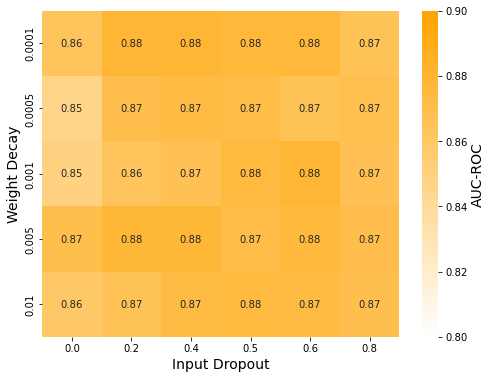

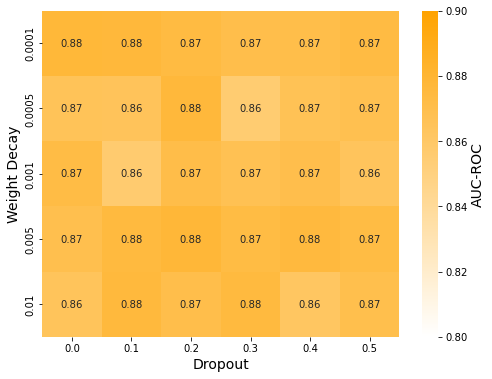

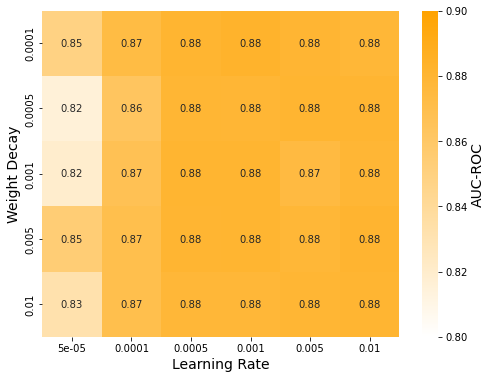

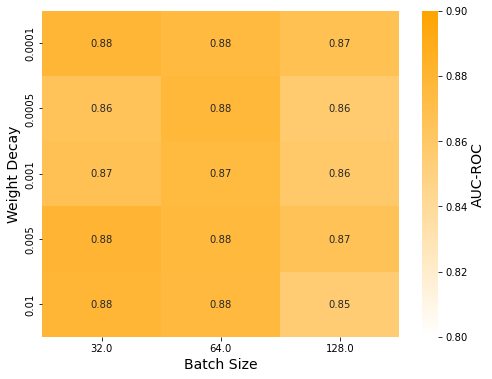

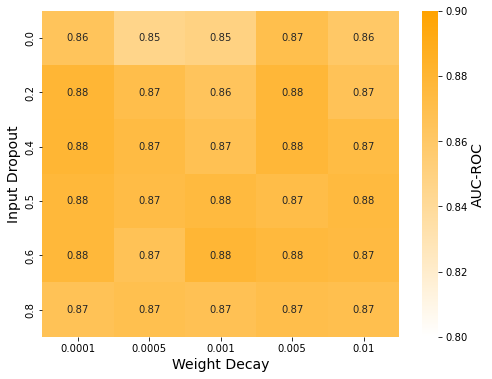

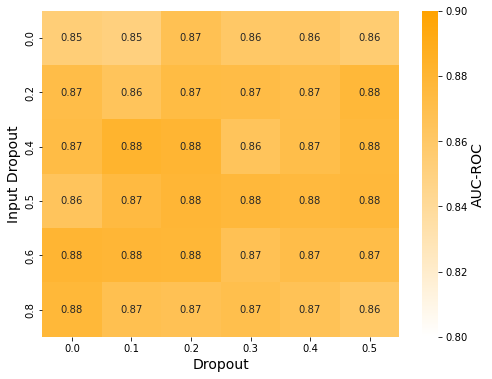

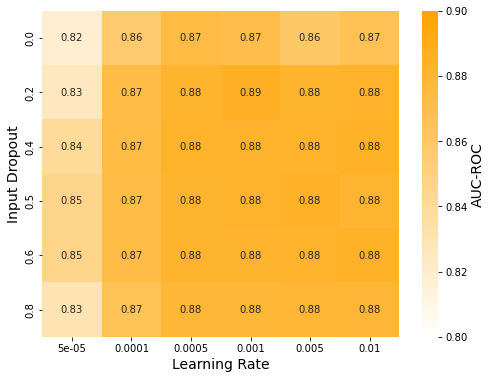

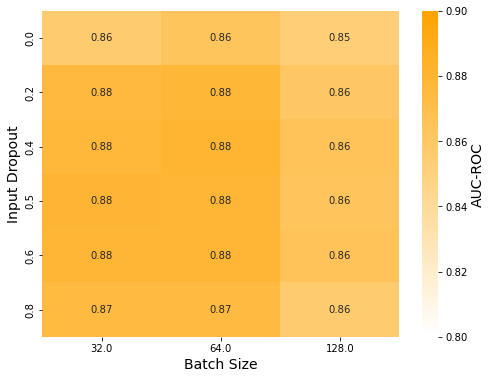

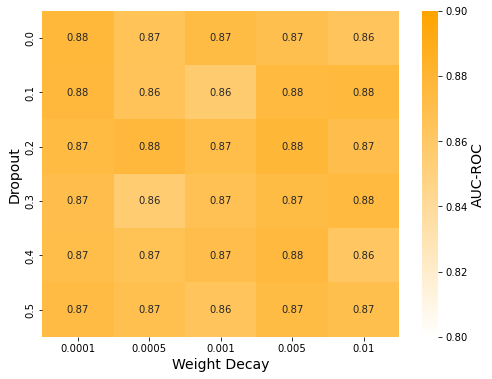

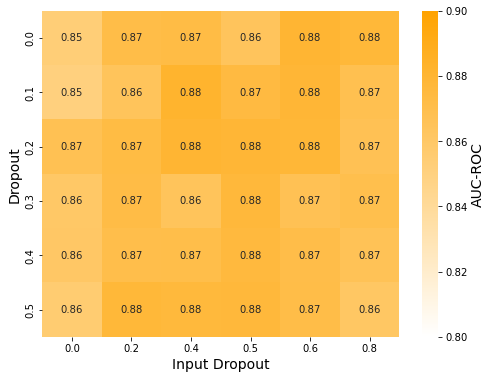

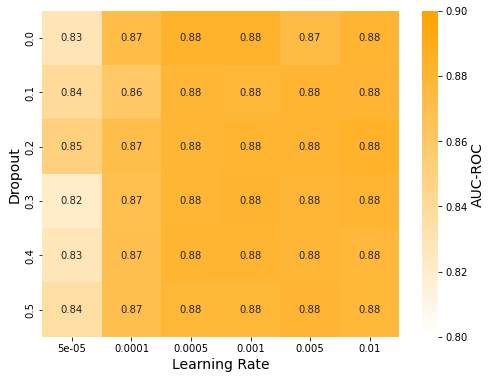

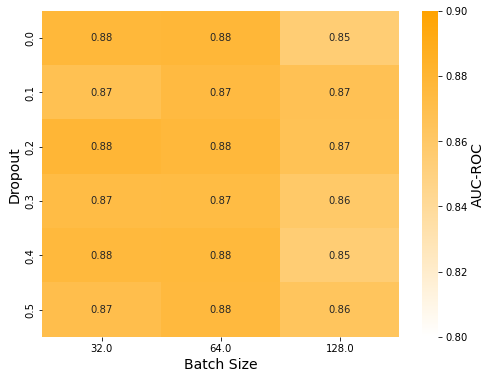

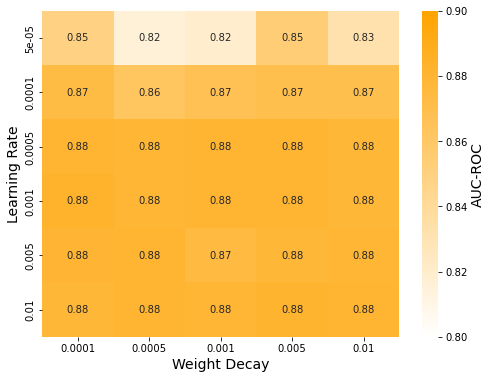

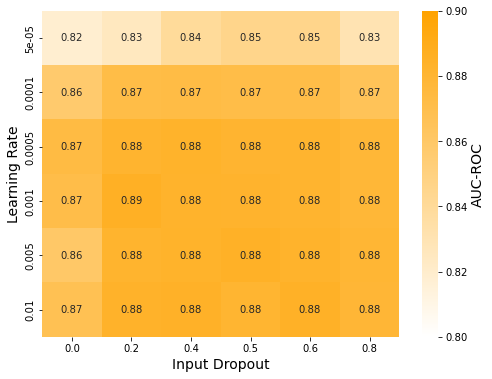

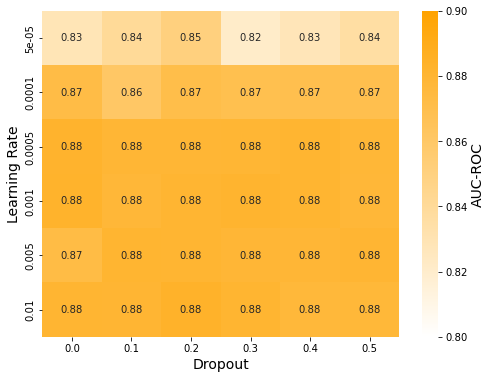

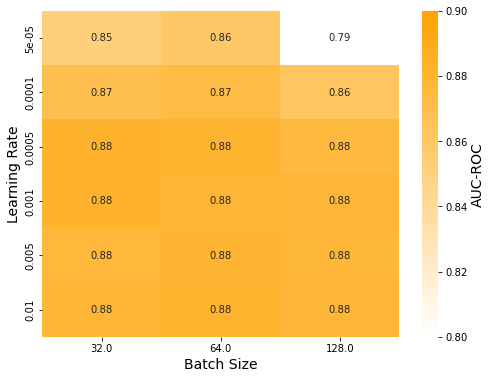

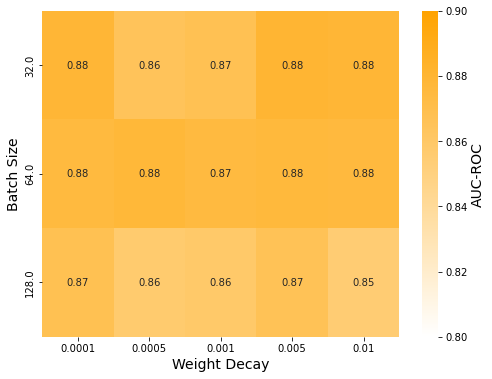

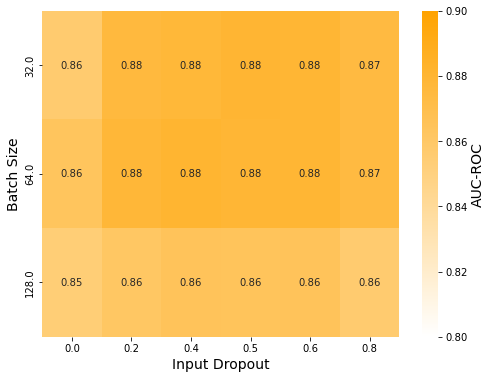

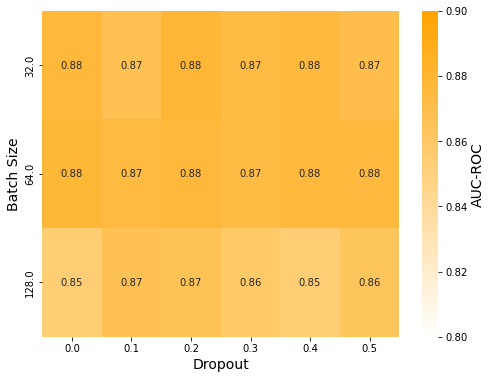

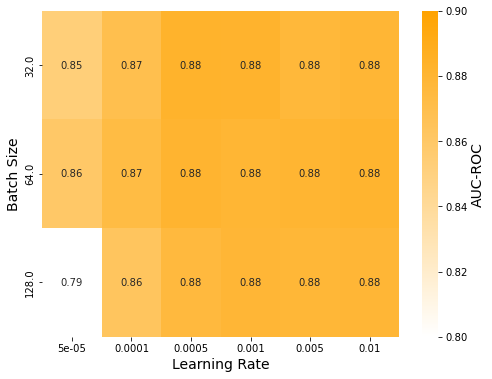

In [25]:
for hparam1 in df.columns[:-3]:
    for hparam2 in df.columns[:-3]:
        if hparam1 != hparam2:
            plot_heatmap(hparam1, hparam2, df)

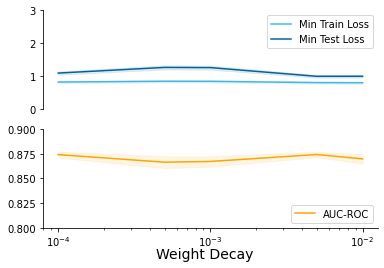

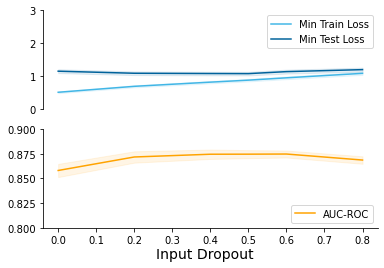

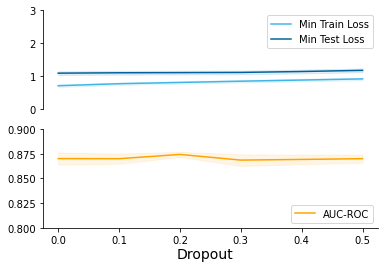

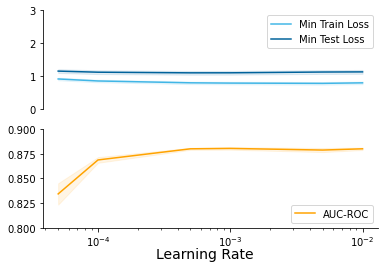

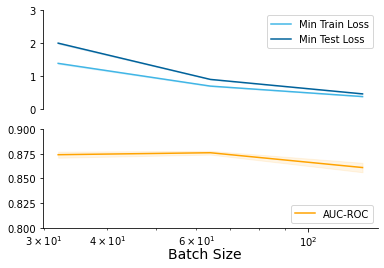

In [33]:
for hparam in df.columns[:-3]:
    plot_curves(hparam, df)

In [15]:
inpd_0_train_df = pd.DataFrame(index=range(400))
for i, d in enumerate(dicts):
    if float(d['input_dropout']) == 0:
        inpd_0_train_df[i] = d['train_loss'] + [np.nan] * (400 - len(d['train_loss']))

inpd_0_test_df = pd.DataFrame(index=range(400))
for i, d in enumerate(dicts):
    if float(d['input_dropout']) == 0:
        inpd_0_test_df[i] = d['test_loss'] + [np.nan] * (400 - len(d['test_loss']))


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  after removing the cwd from sys.path.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  if __name__ == '__main__':


In [16]:
input_dropout_train_loss_curves = {}
input_dropout_test_loss_curves = {}

for v in [0.0, 0.2, 0.4, 0.5, 0.6, 0.8]:
    inpd_train_df = pd.DataFrame(index=range(400))
    for i, d in enumerate(dicts):
        if float(d['input_dropout']) == v:
            inpd_train_df[i] = d['train_loss'] + [np.nan] * (400 - len(d['train_loss']))

    inpd_test_df = pd.DataFrame(index=range(400))
    for i, d in enumerate(dicts):
        if float(d['input_dropout']) == v:
            inpd_test_df[i] = d['test_loss'] + [np.nan] * (400 - len(d['test_loss']))
            
    input_dropout_train_loss_curves[v] = inpd_train_df.mean(axis=1)
    input_dropout_test_loss_curves[v] = inpd_test_df.mean(axis=1)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  del sys.path[0]


In [17]:
def plot_loss_curves(df, fig, ax):
    df.plot(color=['#003354', '#4C91B9', '#79CAEB', '#FFBE5F', '#919496', '#4D4D4F'], ax=ax)
    ax.set_ylabel('Loss', size=14)
    ax.set_xlabel('Epoch', size=14)
    ax.spines[['right', 'top']].set_visible(False)

Text(0.5, 1.0, 'Input Dropout effect on Test Loss')

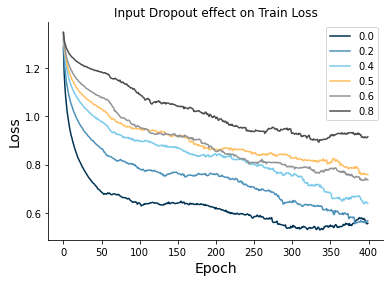

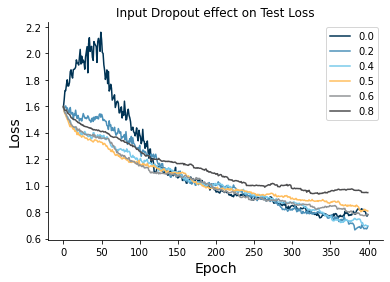

In [15]:
plot_loss_curves(pd.DataFrame(input_dropout_train_loss_curves))
plt.title('Input Dropout effect on Train Loss')
plot_loss_curves(pd.DataFrame(input_dropout_test_loss_curves))
plt.title('Input Dropout effect on Test Loss')

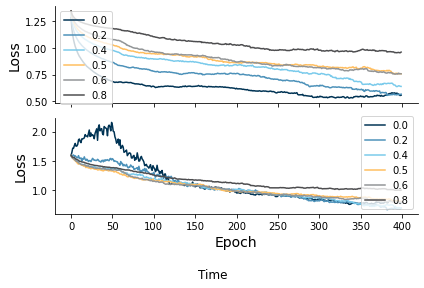

In [18]:
fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True)
fig.supxlabel('Time')
plot_loss_curves(pd.DataFrame(input_dropout_train_loss_curves), fig, ax[0])
plot_loss_curves(pd.DataFrame(input_dropout_test_loss_curves), fig, ax[1])

plt.tight_layout()